# Import Libraries

In [26]:
# Importing the import required libraries for the analysis.
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import re
import nltk
import spacy
from wordcloud import WordCloud, STOPWORDS
from PIL import Image


from nltk.corpus import stopwords
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

# Exploratory Data Analysis

In [27]:
data = pd.read_csv('CHATGPT_REVIEWS.csv')

In [28]:
data.shape

(38241, 9)

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38241 entries, 0 to 38240
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          38241 non-null  int64  
 1   review_id           38241 non-null  object 
 2   pseudo_author_id    38241 non-null  float64
 3   author_name         38241 non-null  object 
 4   review_text         38241 non-null  object 
 5   rating              38241 non-null  int64  
 6   review_likes        38241 non-null  int64  
 7   author_app_version  32843 non-null  object 
 8   review_timestamp    38241 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 2.6+ MB


In [30]:
data.describe()

,Unnamed: 0,pseudo_author_id,rating,review_likes
count,38241.000000,3.824100e+04,38241.000000,38241.000000
mean,19120.000000,3.173204e+20,4.409822,0.816349
std,11039.370159,2.158367e+20,1.213238,15.106968
min,0.000000,1.000170e+20,1.000000,0.000000
25%,9560.000000,1.757550e+20,4.000000,0.000000
50%,19120.000000,2.518370e+20,5.000000,0.000000
75%,28680.000000,3.295920e+20,5.000000,0.000000
max,38240.000000,9.999300e+20,5.000000,1079.000000


In [31]:
data.describe(include='object')

,review_id,author_name,review_text,author_app_version,review_timestamp
count,38241,38241,38241,32843,38241
unique,38241,31106,31078,26,29456
top,1558c5f6-90b3-468c-856b-428e353758a4,****,Good,1.2023.263,25-07-2023 15:10
freq,1,367,485,4446,117


<h3> Analysis of Rating column </h3>

In [32]:
#Rating Distribution
data['rating'].value_counts().sort_index()

rating
1     3274
2      771
3     1562
4     4036
5    28598
Name: count, dtype: int64

In [33]:
data['rating'].value_counts(normalize=True).mul(100).round(2).sort_index()

rating
1     8.56
2     2.02
3     4.08
4    10.55
5    74.78
Name: proportion, dtype: float64

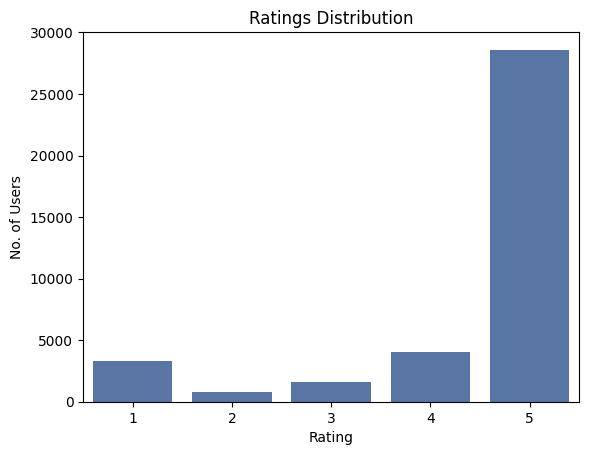

In [34]:
#Plot
palette = "deep"
sns.set_palette(palette)

sns.countplot(data=data, x='rating')

plt.xlabel('Rating')
plt.ylabel('No. of Users')
plt.title('Ratings Distribution')

plt.show()

# Data Preprocessing

In [35]:
#Find no. of missing values in each column
data.isnull().sum().sort_values(ascending=False)

author_app_version    5398
Unnamed: 0               0
review_id                0
pseudo_author_id         0
author_name              0
review_text              0
rating                   0
review_likes             0
review_timestamp         0
dtype: int64

In [36]:
#Combine Review Time and Review
data['complete_review'] = data['review_timestamp'] +' .'+data['review_text']

In [37]:
#Drop some columns which we won't use for sentiment analysis of review
remove_cols = ['review_id','pseudo_author_id','author_name']
data = data.drop(remove_cols,axis='columns')

In [38]:
data.head()

,Unnamed: 0,review_text,rating,review_likes,author_app_version,review_timestamp,complete_review
0,0,What type this app,4,3,1.0.0016,25-07-2023 15:01,25-07-2023 15:01 .What type this app
1,1,I am the first one 😁😁,5,3,NaN,25-07-2023 15:01,25-07-2023 15:01 .I am the first one 😁😁
2,2,Bahut Achcha work,5,2,1.0.0016,25-07-2023 15:02,25-07-2023 15:02 .Bahut Achcha work
3,3,Pretty good UI,4,0,1.0.0016,25-07-2023 15:03,25-07-2023 15:03 .Pretty good UI
4,4,First,5,0,1.0.0016,25-07-2023 15:03,25-07-2023 15:03 .First


1. Convert all the reviews to lowercase

In [39]:
data['complete_review'] = data['complete_review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['complete_review'].head()

0       25-07-2023 15:01 .what type this app
1    25-07-2023 15:01 .i am the first one 😁😁
2        25-07-2023 15:02 .bahut achcha work
3           25-07-2023 15:03 .pretty good ui
4                    25-07-2023 15:03 .first
Name: complete_review, dtype: object

2. Remove Punctuation

In [40]:
data['complete_review'] = data['complete_review'].str.replace('[^\w\s]','')

3. Remove Emojis

In [41]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
data['complete_review'] = data['complete_review'].apply(lambda x: remove_emoji(x))

4. Remove Stopwords

Stopwords are commonly used words (i.e. “the”, “a”, “an”) that do not add meaning to a sentence and can be ignored without having a drastic effect on the meaning of the sentence.

In [42]:
stop = stopwords.words('english')
data['complete_review'] = data['complete_review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

5. Apply Lemmatization

In [43]:
def space(comment):
    doc = nlp(comment)
    return " ".join([token.lemma_ for token in doc])
data['complete_review']= data['complete_review'].apply(space)


6. Remove certain words

  These are specific to app and won't show any sentiments

In [44]:
words_to_remove = ['chatgpt','app','chatgpts','chat','gpt','android','gpt4','phone','number','ai','use','io']
data['complete_review'] = data['complete_review'].apply(lambda x: " ".join(x for x in x.split() if x not in words_to_remove))

7. Map ratings to positive, negative & neutral sentiment

0 will represent negative sentiment

1 will represent neutral sentiment

2 will represent positive sentiment


In [45]:
print(data.columns)

Index(['Unnamed: 0', 'review_text', 'rating', 'review_likes',
       'author_app_version', 'review_timestamp', 'complete_review'],
      dtype='object')


In [46]:
# Assuming 'rating' is the column containing numerical ratings

data['sentiment'] = data['rating'].apply(lambda rating: 2 if rating > 3 else (1 if rating == 3 else 0))


In [47]:
data['sentiment'].value_counts(normalize=True).mul(100).round(2)

sentiment
2    85.34
0    10.58
1     4.08
Name: proportion, dtype: float64

Data is Imbalanced as about 66% of sentiment is positive, 24% is negative and 9.5% is neutral.

# Reviews Analysis

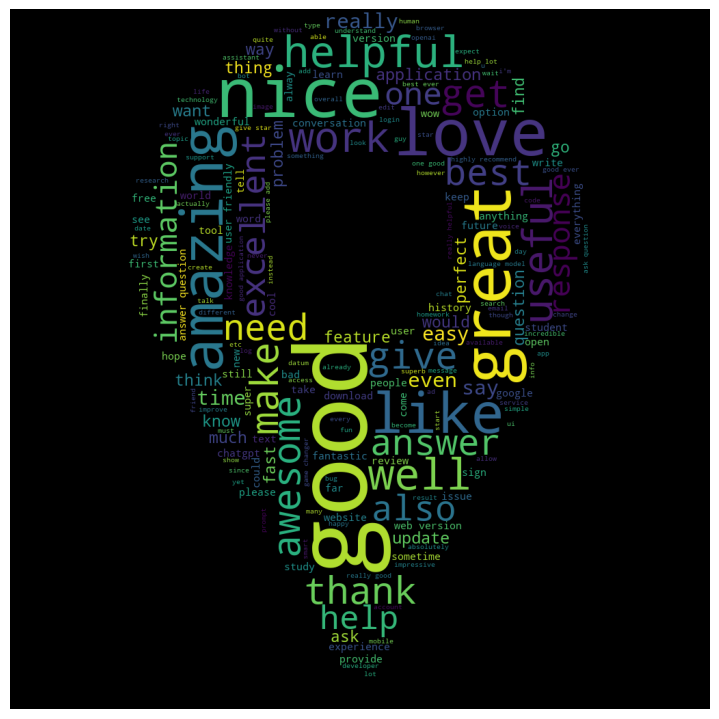

In [48]:
#Analysis of Review field
stopword = set(stopwords.words('english'))
text = " ".join(review for review in data.complete_review)
mask = np.array(Image.open("./loc.png"))
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopword,
                min_font_size = 10, mask=mask).generate(text)

# plot the WordCloud image
plt.figure(figsize = (7, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('review_sentiment.png')
plt.show()

In [49]:
#positive negative & neutral sentiment:
positive = data[data['sentiment'] == 2]
negative = data[data['sentiment'] == 0]
neutral = data[data['sentiment'] == 1]

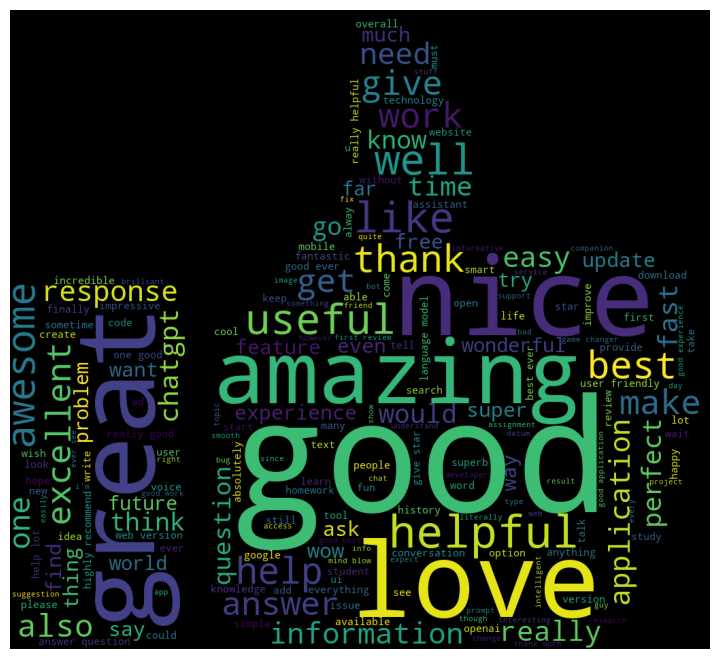

In [50]:
#Positive Setiment
stopword = set(stopwords.words('english'))
text = " ".join(review for review in positive.complete_review)
mask = np.array(Image.open("./thumbs_up.png"))
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopword,
                min_font_size = 10, mask=mask).generate(text)

# plot the WordCloud image
plt.figure(figsize = (7, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('positive_sentiment.png')
plt.show()

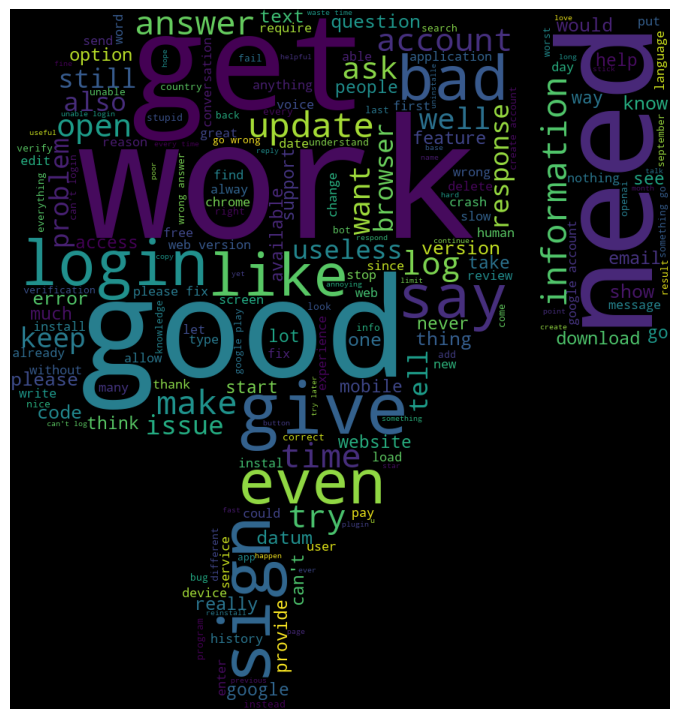

In [51]:
#Negative Setiment
stopword = set(stopwords.words('english'))
text = " ".join(review for review in negative.complete_review)
mask = np.array(Image.open("./thumbs_down.png"))
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopword,
                min_font_size = 10, mask=mask).generate(text)

# plot the WordCloud image
plt.figure(figsize = (7, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('negative_sentiment.png')
plt.show()

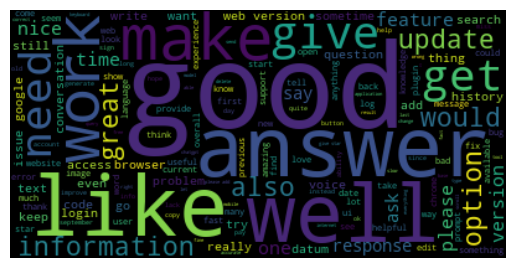

In [52]:
#Neutral Sentiment
stopword = set(stopwords.words('english'))
text = " ".join(review for review in neutral.complete_review)
wordcloud = WordCloud(stopwords=stopword).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Sentiment Analysis Model

<h3> Bag of Word Vectorization </h3>

In [53]:
#Pre-Prcoessing and Bag of Word Vectorization using Count Vectorizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
X = cv.fit_transform(data['complete_review'])
y = data['sentiment']

<h3> Handle Imbalanced Data </h3>

In [54]:
# Instantiate the SMOTE object
smote = SMOTE()

# Perform oversampling
X_oversampled, y_oversampled = smote.fit_resample(X, y)

In [55]:

# Feature extraction
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(data['complete_review'])
y = data['sentiment']


<h3> Train Test Split </h3>

In [56]:
#Train Test split
X_train, X_test, y_train, y_test = train_test_split(X_oversampled,
                                                  y_oversampled,
                                                  test_size=0.15,
                                                  random_state=17,stratify=y_oversampled)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(83216, 13205)
(14686, 13205)
(83216,)
(14686,)


<h3> Multinomial Naive Bayes </h3>

In [57]:
#Training the model
MNB = MultinomialNB()
MNB.fit(X_train, y_train)

#Caluclating the accuracy score of the model
y_pred = MNB.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.53      0.68      0.60      3832
           1       0.76      0.54      0.63      6814
           2       0.72      0.88      0.79      4040

    accuracy                           0.67     14686
   macro avg       0.67      0.70      0.67     14686
weighted avg       0.69      0.67      0.67     14686



<h3> Logistic Regression </h3>

In [58]:
# Initialize and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.63      0.72      0.68      4271
           1       0.74      0.69      0.71      5200
           2       0.97      0.91      0.94      5215

    accuracy                           0.78     14686
   macro avg       0.78      0.78      0.78     14686
weighted avg       0.79      0.78      0.78     14686



<h3> XGBoost </h3>

In [59]:
# Create DMatrix for training and testing data
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set the parameters for XGBoost
params = {
    'objective': 'multi:softmax',  # Set the objective function for multi-class classification
    'num_class': 3,      # Number of classes in the dataset
    'eval_metric': 'merror',        # Evaluation metric (multi-class classification error rate)
    'eta': 0.4,                    # Learning rate
    'max_depth': 6,                # Maximum depth of a tree
    'subsample': 0.8,              # Subsample ratio of the training instances
    'colsample_bytree': 0.8,       # Subsample ratio of features when constructing each tree
    'seed': 42                     # Random seed for reproducibility
}

# Train the XGBoost model
num_rounds = 100  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the testing data
preds = model.predict(dtest)
pred_labels = [int(pred) for pred in preds]

print(classification_report(pred_labels, y_test))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      4461
           1       0.91      0.92      0.91      4833
           2       0.99      0.90      0.94      5392

    accuracy                           0.92     14686
   macro avg       0.92      0.92      0.92     14686
weighted avg       0.92      0.92      0.92     14686



#Conclusion

The best-performing model was identified as XGBoost, which achieved an accuracy of 92% with the f1-score of 0.92 and above for all the labels(positive,negative & neutral). This model demonstrates the ability to accurately predict sentiment based on ChatGPT android reviews.

Overall, with the developed sentiment analysis model, we can effectively analyze and understand the sentiment expressed in ChatGPT reviews. This provides valuable insights for businesses, helping them make informed decisions, improve customer satisfaction, and enhance their products and services based on customer feedback.